## CNN inference example

Template example of running a TensorFlow 1-D CNN model for wet–dry classification. By default, the model is pre-trained on a dataset from Czechia.

In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import pycomlink as pycml
# importation of the submodule for running the inference 
from pycomlink.processing.tensorflow_utils import run_inference

In [26]:
# Load data

data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [27]:
cmls["tl1"] = cmls["tl"].sel(channel_id = 'channel_1')
cmls["tl2"] = cmls["tl"].sel(channel_id = 'channel_2')

## CNN inference 

In [28]:
results = run_inference.wet_dry_1d_cnn(ds=cmls, return_ds=False)
results

[→] Using cached file: /home/jovyan/toufikshit/pycomlink/model_cnn/CNN__model_v0_cz.json
[→] Using cached file: /home/jovyan/toufikshit/pycomlink/model_cnn/CNN__model_v0_cz.weights.h5
[✓] Model loaded and compiled.


/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


Storing predictions (model): 100%|██████████| 3/3 [00:00<00:00, 3821.11CML/s]


<xarray.DataArray 'CNN' (time: 15840, cml_id: 3)> Size: 190kB
array([[       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       ...,
       [0.00544405, 0.00437634, 0.00475321],
       [0.00629856, 0.00450195, 0.00510201],
       [0.01305616, 0.00438147, 0.00533479]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id   (cml_id) <U3 36B '0' '10' '370'
Attributes:
    description:  Predicted probabilities from CNN model
    source:       Model Trained on Czechia D

In [29]:
# storing the probabilities  predictions of the cnn model 
cmls["CNN"] = results

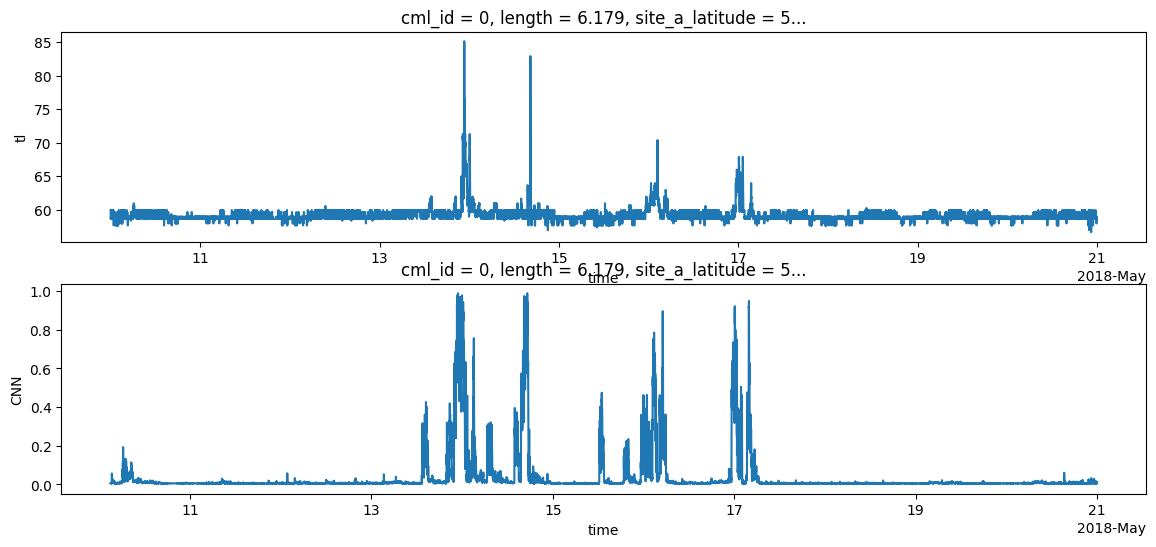

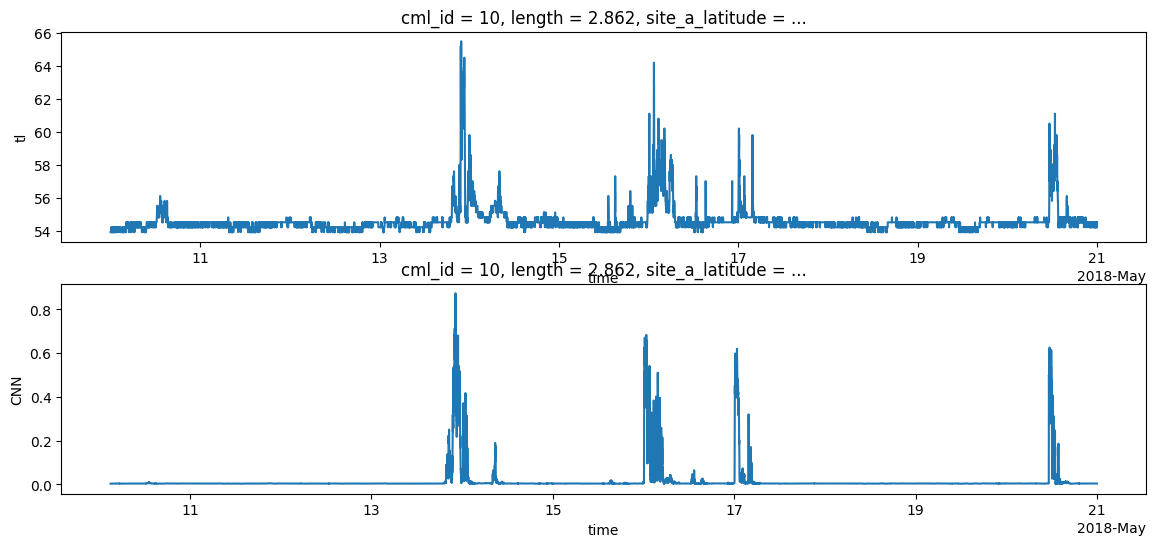

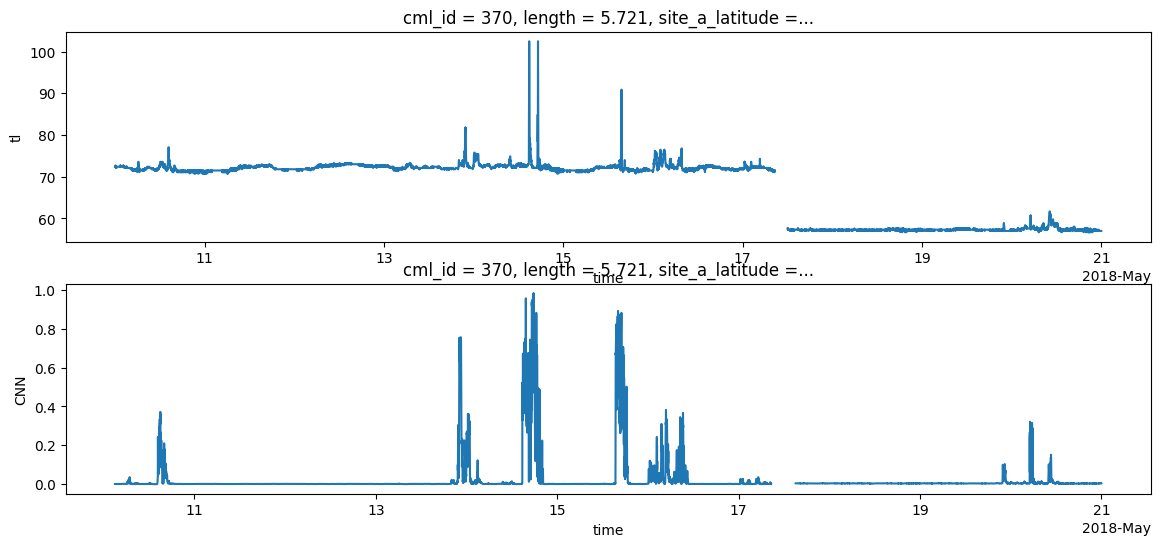

In [30]:
# plotting the results 
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    cmls.tl.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    cmls.CNN.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    
